In [10]:
#!pip install scikit-learn
#!python3 -m pip install libpecos
#!pip install scipy
#!pip install matplotlib
#!pip install orjson
#!pip install kagglehub

In [11]:
import os
import json
import csv
import re
import math
import ast
import unicodedata
from collections import Counter, deque
from pathlib import Path
from IPython.display import HTML, display
import random

import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import vstack
from scipy.stats import linregress
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, jaccard_score
import joblib

import orjson
import kagglehub
from tqdm import tqdm

from pecos.utils.featurization.text.preprocess import Preprocessor
from pecos.xmc.xlinear.model import XLinearModel
from pecos.xmc import Indexer, LabelEmbeddingFactory
from pecos.utils import smat_util

/home/aditya/Downloads/Wiki_extreme_classification/wiki_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [14]:
os.makedirs('data', exist_ok=True)

for number in range(1, 38):
    file_name = f"enwiki_namespace_0/enwiki_namespace_0_{number}.jsonl"
    print(f"\nDownloading {file_name}...")

    try:

        downloaded_path = kagglehub.dataset_download(
            "wikimedia-foundation/wikipedia-structured-contents",
            path=file_name
        )

        base_name = os.path.basename(downloaded_path)

        new_path = os.path.join("data", base_name)

        if os.path.exists(downloaded_path):
            if os.path.exists(new_path):
                os.remove(new_path)
            os.rename(downloaded_path, new_path)
            print(f"Successfully saved to {new_path}")
        else:
            print(f"Warning: Downloaded file not found at {downloaded_path}")

    except Exception as e:
        print(f"Error downloading {file_name}: {str(e)}")

print("\nDownload process completed")

100%|██████████| 2.00G/2.00G [01:07<00:00, 31.6MB/s]


Successfully saved to data/enwiki_namespace_0_1.jsonl



100%|██████████| 2.00G/2.00G [01:14<00:00, 28.9MB/s]


Successfully saved to data/enwiki_namespace_0_2.jsonl



100%|██████████| 2.00G/2.00G [01:10<00:00, 30.4MB/s]


Successfully saved to data/enwiki_namespace_0_3.jsonl



100%|██████████| 2.00G/2.00G [01:09<00:00, 30.9MB/s]


Successfully saved to data/enwiki_namespace_0_4.jsonl



100%|██████████| 2.00G/2.00G [01:06<00:00, 32.5MB/s]


Successfully saved to data/enwiki_namespace_0_5.jsonl



100%|██████████| 2.00G/2.00G [01:15<00:00, 28.3MB/s]


Successfully saved to data/enwiki_namespace_0_6.jsonl



100%|██████████| 2.00G/2.00G [01:02<00:00, 34.4MB/s]


Successfully saved to data/enwiki_namespace_0_7.jsonl



100%|██████████| 2.00G/2.00G [01:01<00:00, 35.0MB/s]


Successfully saved to data/enwiki_namespace_0_8.jsonl



100%|██████████| 2.00G/2.00G [01:01<00:00, 34.9MB/s]


Successfully saved to data/enwiki_namespace_0_9.jsonl



100%|██████████| 2.00G/2.00G [00:59<00:00, 35.8MB/s]


Successfully saved to data/enwiki_namespace_0_10.jsonl



100%|██████████| 2.00G/2.00G [01:10<00:00, 30.3MB/s]


Successfully saved to data/enwiki_namespace_0_11.jsonl



100%|██████████| 2.00G/2.00G [01:02<00:00, 34.6MB/s]


Successfully saved to data/enwiki_namespace_0_12.jsonl



100%|██████████| 2.00G/2.00G [01:09<00:00, 30.9MB/s]


Successfully saved to data/enwiki_namespace_0_13.jsonl



100%|██████████| 2.00G/2.00G [01:09<00:00, 30.8MB/s]


Successfully saved to data/enwiki_namespace_0_14.jsonl



100%|██████████| 2.00G/2.00G [01:10<00:00, 30.7MB/s]


Successfully saved to data/enwiki_namespace_0_15.jsonl



100%|██████████| 2.00G/2.00G [01:00<00:00, 35.4MB/s]


Successfully saved to data/enwiki_namespace_0_16.jsonl



100%|██████████| 2.00G/2.00G [01:15<00:00, 28.5MB/s]


Successfully saved to data/enwiki_namespace_0_17.jsonl



100%|██████████| 2.00G/2.00G [01:00<00:00, 35.6MB/s]


Successfully saved to data/enwiki_namespace_0_18.jsonl



100%|██████████| 2.00G/2.00G [00:59<00:00, 36.3MB/s]


Successfully saved to data/enwiki_namespace_0_19.jsonl



100%|██████████| 2.00G/2.00G [01:00<00:00, 35.7MB/s]


Successfully saved to data/enwiki_namespace_0_20.jsonl



100%|██████████| 2.00G/2.00G [00:59<00:00, 35.8MB/s]


Successfully saved to data/enwiki_namespace_0_21.jsonl



100%|██████████| 2.00G/2.00G [01:02<00:00, 34.4MB/s]


Successfully saved to data/enwiki_namespace_0_22.jsonl



100%|██████████| 2.00G/2.00G [01:10<00:00, 30.5MB/s]


Successfully saved to data/enwiki_namespace_0_23.jsonl



100%|██████████| 2.00G/2.00G [01:12<00:00, 29.6MB/s]


Successfully saved to data/enwiki_namespace_0_24.jsonl



100%|██████████| 2.00G/2.00G [01:05<00:00, 32.8MB/s]


Successfully saved to data/enwiki_namespace_0_25.jsonl



100%|██████████| 2.00G/2.00G [01:14<00:00, 28.7MB/s]


Successfully saved to data/enwiki_namespace_0_26.jsonl



100%|██████████| 2.00G/2.00G [01:14<00:00, 28.7MB/s]


Successfully saved to data/enwiki_namespace_0_27.jsonl



100%|██████████| 2.00G/2.00G [01:28<00:00, 24.2MB/s]


Successfully saved to data/enwiki_namespace_0_28.jsonl



100%|██████████| 2.00G/2.00G [01:13<00:00, 29.2MB/s]


Successfully saved to data/enwiki_namespace_0_29.jsonl



100%|██████████| 2.00G/2.00G [01:16<00:00, 28.0MB/s]


Successfully saved to data/enwiki_namespace_0_30.jsonl



100%|██████████| 2.00G/2.00G [01:34<00:00, 22.8MB/s]


Successfully saved to data/enwiki_namespace_0_31.jsonl



100%|██████████| 2.00G/2.00G [01:25<00:00, 25.2MB/s]


Successfully saved to data/enwiki_namespace_0_32.jsonl



100%|██████████| 2.00G/2.00G [01:24<00:00, 25.5MB/s]


Successfully saved to data/enwiki_namespace_0_33.jsonl



100%|██████████| 2.00G/2.00G [01:39<00:00, 21.6MB/s]


Successfully saved to data/enwiki_namespace_0_34.jsonl



100%|██████████| 2.00G/2.00G [01:21<00:00, 26.3MB/s]


Successfully saved to data/enwiki_namespace_0_35.jsonl



100%|██████████| 2.00G/2.00G [01:11<00:00, 30.2MB/s]


Successfully saved to data/enwiki_namespace_0_36.jsonl



100%|██████████| 110M/110M [00:05<00:00, 22.4MB/s] 


Successfully saved to data/enwiki_namespace_0_37.jsonl

Download process completed


In [ ]:
def parse_json(x):
    if isinstance(x, str):
        try:
            return orjson.loads(x)
        except orjson.JSONDecodeError:
            return None
    elif isinstance(x, float) and math.isnan(x):
        return None
    return x

def extract_links(section):
    links = set()
    stack = [section]
    while stack:
        item = stack.pop()
        if isinstance(item, dict):
            for link in item.get('links', []):
                url = link.get('url')
                if url: links.add(url)
                for img in link.get('images', []):
                    img_url = img.get('content_url')
                    if img_url: links.add(img_url)
            for img in item.get('images', []):
                img_url = img.get('content_url')
                if img_url: links.add(img_url)
            stack.extend(item.get('has_parts', []))
        elif isinstance(item, list):
            stack.extend(item)
    return list(links)

def calculate_section_word_count(section):
    if section is None:
        return 0
    word_count = 0
    queue = deque([section])
    while queue:
        item = queue.popleft()
        if isinstance(item, dict):
            text_value = item.get('value')
            if isinstance(text_value, str):
                word_count += len(text_value.strip().split())
            queue.extend(item.get('has_parts', []))
        elif isinstance(item, list):
            queue.extend(item)
    return word_count

def create_links_summary_and_counts(base_dir, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    summary_path = output_dir / "all_links_summary.csv"
    link_counts_path = output_dir / "unique_links_counts.csv"

    link_counter = Counter()

    with open(summary_path, mode='w', newline='', encoding='utf-8') as summary_file:
        summary_writer = csv.writer(summary_file)
        summary_writer.writerow(['identifier', 'name', 'url', 'total_num_links', 'text_length', 'link_density'])

        for i in tqdm(range(38), desc="Processing JSONL shards"):
            input_file = Path(base_dir) / f"enwiki_namespace_0_{i}.jsonl"
            if not input_file.exists():
                continue

            with open(input_file, 'rb') as f:
                for line in f:
                    try:
                        data = orjson.loads(line)

                        section_links = extract_links(data.get('sections', []))
                        infobox_links = extract_links(data.get('infoboxes', []))
                        unique_links = list(set(section_links + infobox_links))
                        total_links = len(unique_links)

                        link_counter.update(unique_links)

                        text_length = calculate_section_word_count(data.get('sections', []))
                        link_density = total_links / text_length if text_length > 0 else 0

                        summary_writer.writerow([
                            data['identifier'],
                            data['name'],
                            data.get('url', ''),
                            total_links,
                            text_length,
                            link_density
                        ])

                    except orjson.JSONDecodeError:
                        continue

    with open(link_counts_path, mode='w', newline='', encoding='utf-8') as counts_file:
        counts_writer = csv.writer(counts_file)
        counts_writer.writerow(['url', 'count'])
        for url, count in link_counter.items():
            counts_writer.writerow([url, count])

    tqdm.write(f"Saved per-document summary to: {summary_path}")
    tqdm.write(f"Saved unique link counts to: {link_counts_path}")


base_dir = "data"
output_dir = Path(base_dir) / "processed_output"
output_dir.mkdir(parents=True, exist_ok=True)



In [16]:
create_links_summary_and_counts(base_dir, output_dir)

Processing JSONL shards: 100%|██████████| 38/38 [22:12<00:00, 35.05s/it]


Saved per-document summary to: data/processed_output/all_links_summary.csv
Saved unique link counts to: data/processed_output/unique_links_counts.csv


In [17]:
base_dir = "data"
output_dir = Path(base_dir) / "processed_output"
summary_df = pd.read_csv(output_dir / "all_links_summary.csv")
counts_df = pd.read_csv(output_dir / "unique_links_counts.csv")

In [106]:
summary_df

,identifier,name,url,total_num_links,text_length,link_density
0,40477619,2013 Tashkent Open – Doubles,https://en.wikipedia.org/wiki/2013_Tashkent_Op...,39,121,0.32
1,25829972,Thomas Claughton (MP),https://en.wikipedia.org/wiki/Thomas_Claughton...,15,72,0.21
2,28049975,1999–2000 Newcastle United F.C. season,https://en.wikipedia.org/wiki/1999%E2%80%93200...,37,364,0.10
3,12895105,Gwendolyn Holbrow,https://en.wikipedia.org/wiki/Gwendolyn_Holbrow,21,1063,0.02
4,53572039,2017 İstanbul Cup,https://en.wikipedia.org/wiki/2017_%C4%B0stanb...,69,224,0.31
...,...,...,...,...,...,...
7095516,41687,Self-synchronizing code,https://en.wikipedia.org/wiki/Self-synchronizi...,19,306,0.06
7095517,14162027,Panbari Mosque,https://en.wikipedia.org/wiki/Panbari_Mosque,46,621,0.07
7095518,47782438,List of Clube Atlético Mineiro seasons,https://en.wikipedia.org/wiki/List_of_Clube_At...,35,606,0.06
7095519,7998296,The Ploughman's Lunch,https://en.wikipedia.org/wiki/The_Ploughman%27...,36,833,0.04


In [107]:
url_to_title = dict(zip(summary_df['url'], summary_df['name']))

In [108]:
counts_df['title'] = counts_df['url'].map(url_to_title)

In [109]:
missing_titles_mask = counts_df['title'].isna()

In [110]:
pattern = r'/([^/#?]+)(?:[#?].*)?$'
counts_df.loc[missing_titles_mask, 'title'] = counts_df.loc[missing_titles_mask, 'url'].str.extract(pattern)[0]

In [111]:
counts_df.sort_values('count', ascending=False)

,url,count,title
288,https://upload.wikimedia.org/wikipedia/commons...,485104,6px-Red_pog.svg.png
186,https://en.wikipedia.org/wiki/Taxonomy_(biology),444000,Taxonomy (biology)
296,https://en.wikipedia.org/wiki/Time_zone,435673,Time zone
198,https://upload.wikimedia.org/wikipedia/commons...,398690,15px-OOjs_UI_icon_edit-ltr.svg.png
116,https://en.wikipedia.org/wiki/United_States,355943,United States
...,...,...,...
8969970,https://geohack.toolforge.org/geohack.php?page...,1,geohack.php
24526271,https://en.wikipedia.org/wiki/Sindhi_Canadians...,1,Sindhi_Canadians
24526270,https://en.wikipedia.org/wiki/Sindhi_Canadians...,1,Sindhi_Canadians
24526269,https://en.wikipedia.org/wiki/Digimon_Vermilli...,1,Digimon_Vermillion


In [112]:
pattern = r'\.(?:svg|png|jpg|jpeg|gif|webp|asp|pdf|html|php|phtml|page|aspx)(?:\?[^/]+)?$'

counts_df = counts_df[
    ~counts_df['title'].isna() &
    ~counts_df['title'].str.contains(pattern, na=False, regex=True, flags=re.IGNORECASE) &
    ~counts_df['title'].str.contains('wiki', na=False, case=False) &
    (counts_df['count'] >= 50)
]

In [113]:
counts_df['count'].describe()

,count
count,"554,300.00"
mean,273.93
std,"2,089.26"
min,50.00
25%,66.00
50%,97.00
75%,186.00
max,"444,000.00"


In [114]:
counts_df.isna().all()

,0
url,False
count,False
title,False


In [36]:
counts_df.to_csv('links.csv',index = False)

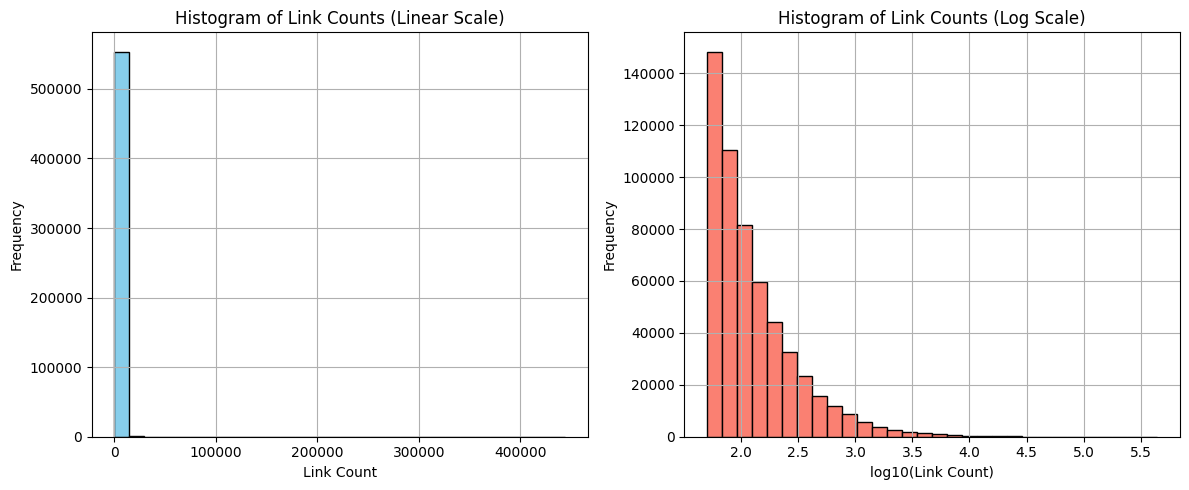

In [38]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(counts_df['count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Link Counts (Linear Scale)')
plt.xlabel('Link Count')
plt.ylabel('Frequency')
plt.grid(True)


plt.subplot(1, 2, 2)
counts = counts_df['count']
counts = counts[counts > 0]
plt.hist(np.log10(counts), bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Link Counts (Log Scale)')
plt.xlabel('log10(Link Count)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


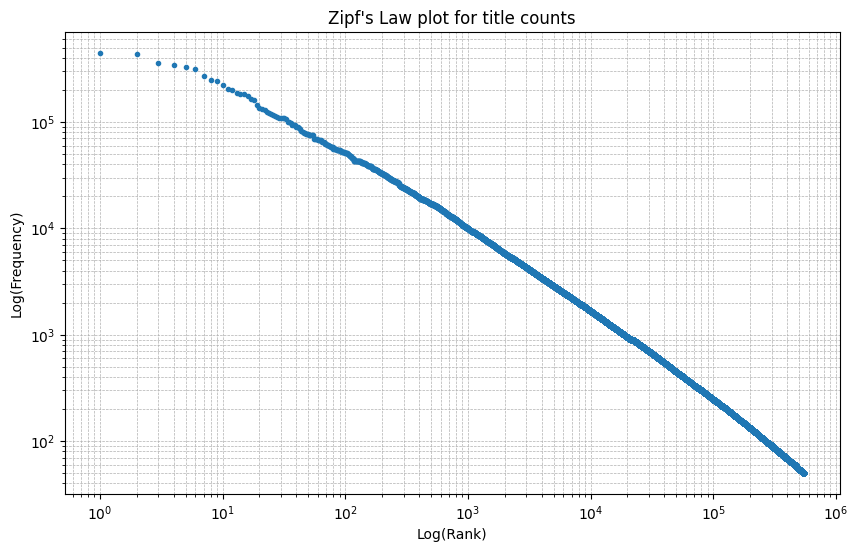

In [39]:
sorted_counts = counts_df['count'].sort_values(ascending=False).reset_index(drop=True)

ranks = np.arange(1, len(sorted_counts) + 1)

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_counts, marker=".", linestyle='none')

plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.title("Zipf's Law plot for title counts")

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


Slope: -0.880, R-squared: 0.997


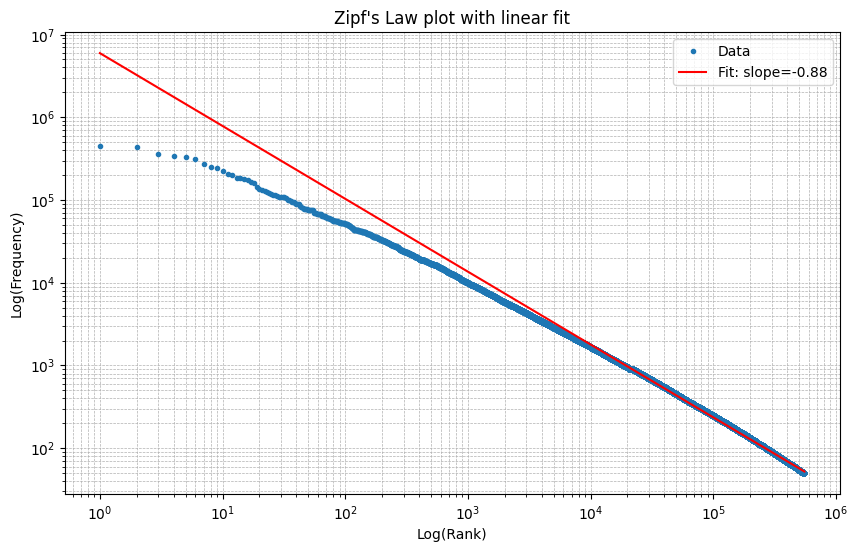

In [40]:
log_ranks = np.log(ranks)
log_counts = np.log(sorted_counts)

slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_counts)

print(f"Slope: {slope:.3f}, R-squared: {r_value**2:.3f}")

plt.figure(figsize=(10, 6))
plt.loglog(ranks, sorted_counts, marker=".", linestyle='none', label='Data')
plt.loglog(ranks, np.exp(intercept) * ranks ** slope, label=f'Fit: slope={slope:.2f}', color='red')

plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.title("Zipf's Law plot with linear fit")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


In [121]:
len(summary_df)

2106911

In [117]:
summary_df = summary_df[~summary_df['name'].astype(str).str.lower().str.startswith(('index', 'list', 'alphabetical', 'timeline', 'iucn','redirect'))]

summary_df = summary_df[(summary_df['total_num_links'] > 25) & (summary_df['text_length'] > 100)]

summary_df = summary_df.sort_values('total_num_links', ascending=False).drop_duplicates(subset='url', keep='first')

summary_df.loc[summary_df['name'].isna(), 'name'] = (
    summary_df.loc[summary_df['name'].isna(), 'url']
    .astype(str)
    .apply(lambda x: x.rstrip('/').split('/')[-1])
)

In [119]:
idx = summary_df.groupby('identifier')['link_density'].idxmax()

In [120]:
summary_df = summary_df.loc[idx]

In [122]:
summary_df

,identifier,name,url,total_num_links,text_length,link_density
7062855,12,Anarchism,https://en.wikipedia.org/wiki/Anarchism,431,6519,0.07
5454002,39,Albedo,https://en.wikipedia.org/wiki/Albedo,123,3810,0.03
5981290,290,A,https://en.wikipedia.org/wiki/A,154,2235,0.07
6206740,303,Alabama,https://en.wikipedia.org/wiki/Alabama,737,12213,0.06
6573377,305,Achilles,https://en.wikipedia.org/wiki/Achilles,392,7874,0.05
...,...,...,...,...,...,...
7074534,77880350,Muwaqqar Chalk-Marl Formation,https://en.wikipedia.org/wiki/Muwaqqar_Chalk-M...,30,293,0.10
7070438,77880411,Royal Crescent Court,https://en.wikipedia.org/wiki/Royal_Crescent_C...,28,268,0.10
7092763,77880702,David J. Danelski,https://en.wikipedia.org/wiki/David_J._Danelski,46,1316,0.03
7079882,77880731,María Adelaida Puerta,https://en.wikipedia.org/wiki/Mar%C3%ADa_Adela...,35,747,0.05


In [123]:
sorted_df = summary_df.sort_values('link_density', ascending=False)

training_data = sorted_df.head(100000)
testing_data = sorted_df.iloc[len(training_data):len(training_data)+1000]
val_data = sorted_df.tail(1000)

training_data.to_csv('training_dataset_page_details.csv', index=False)
testing_data.to_csv('testing_dataset_page_details.csv', index=False)
val_data.to_csv('validation.csv', index=False)

In [124]:
def parse_json(x):
    if isinstance(x, str):
        try:
            return orjson.loads(x)
        except orjson.JSONDecodeError:
            return None
    elif isinstance(x, float) and math.isnan(x):
        return None
    return x

def extract_all_links(item):
    links = set()
    stack = [item]

    while stack:
        current = stack.pop()

        if isinstance(current, dict):
            for link in current.get('links', []):
                if 'url' in link:
                    links.add(link['url'])

            for img in current.get('images', []):
                if 'content_url' in img:
                    links.add(img['content_url'])

            for value in current.values():
                if isinstance(value, (dict, list)):
                    stack.append(value)

        elif isinstance(current, list):
            stack.extend(current)

    return list(links)

def calculate_word_count(text):
    return len(text.split()) if text.strip() else 0

def extract_sections_recursive(section, path=None):
    if path is None:
        path = []

    current_name = section.get('name') or section.get('type')
    if current_name:
        path = path + [current_name]

    results = []
    has_parts = section.get('has_parts', [])

    if section.get('type') in {'paragraph', 'list_item'} and section.get('value'):
        results.append({
            'path': ' > '.join(path),
            'text': section['value'].strip(),
            'node': section
        })
    elif isinstance(has_parts, list) and has_parts:
        for sub in has_parts:
            results.extend(extract_sections_recursive(sub, path))

    return results

def aggregate_links_from_node(node):
    return extract_all_links(node)


def process_file(input_path, training_pages, testing_pages, validation_pages, output_paths, first_flags, url_to_title):
    processed_pages = {'training': set(), 'testing': set(), 'validation': set()}

    def replace_urls_with_titles(url_list):
        titles = []
        for url in url_list:
            title = url_to_title.get(url)
            if title is None and isinstance(url, str):
                title = url.rstrip('/').split('/')[-1]
            if title:
                titles.append(title)
        return titles

    with open(input_path, 'rb') as f, tqdm(desc=f"Reading {input_path.name}", unit="lines") as pbar:
        for line in f:
            try:
                obj = orjson.loads(line)
                identifier = obj.get("identifier")
                title = obj.get("name", "")

                dataset = None
                if identifier in training_pages and not training_pages[identifier]['processed']:
                    dataset = 'training'
                elif identifier in testing_pages and not testing_pages[identifier]['processed']:
                    dataset = 'testing'
                elif identifier in validation_pages and not validation_pages[identifier]['processed']:
                    dataset = 'validation'

                if not dataset:
                    pbar.update(1)
                    continue

                obj['sections'] = parse_json(obj.get('sections', []))
                obj['infoboxes'] = parse_json(obj.get('infoboxes', []))

                rows = []
                sections = obj.get('sections', [])
                if not isinstance(sections, list):
                    sections = [sections] if sections else []

                for section in sections:
                    flattened_sections = extract_sections_recursive(section)

                    for item in flattened_sections:
                        section_text = item['text']
                        if not section_text:
                            continue

                        section_links = aggregate_links_from_node(item['node'])
                        infobox_links = extract_all_links(obj.get('infoboxes', []))
                        all_links = list(set(section_links + infobox_links))
                        link_titles = replace_urls_with_titles(all_links)

                        word_count = calculate_word_count(section_text)
                        link_density = round(len(link_titles)/word_count, 5) if word_count > 0 else 0

                        row = {
                            "identifier": identifier,
                            "title": title,
                            "url": obj.get("url"),
                            "section_text": section_text,
                            "unique_links": link_titles,
                            "text_length": word_count,
                            "links_to_text_ratio": link_density,
                            "section_link_count": len(link_titles),
                            "section_path": item['path']
                        }
                        rows.append(row)

                merged_rows = []
                temp_row = None
                for row in rows:
                    if temp_row is None:
                        temp_row = row
                    else:
                        combined_text = temp_row['section_text'] + ' ' + row['section_text']
                        combined_word_count = calculate_word_count(combined_text)

                        if combined_word_count <= 450:
                            temp_row['section_text'] = combined_text
                            temp_row['unique_links'] = list(set(temp_row['unique_links'] + row['unique_links']))
                            temp_row['text_length'] = combined_word_count
                            temp_row['section_link_count'] = len(temp_row['unique_links'])
                            temp_row['links_to_text_ratio'] = round(temp_row['section_link_count'] / temp_row['text_length'], 5) if temp_row['text_length'] > 0 else 0
                        else:
                            merged_rows.append(temp_row)
                            temp_row = row

                if temp_row:
                    merged_rows.append(temp_row)

                rows = merged_rows

                if not rows:
                    pbar.update(1)
                    continue

                df = pd.DataFrame(rows)
                df.to_csv(output_paths[dataset], mode='a', header=first_flags[dataset], index=False)
                first_flags[dataset] = False

                if dataset == 'training':
                    training_pages[identifier]['processed'] = True
                elif dataset == 'testing':
                    testing_pages[identifier]['processed'] = True
                elif dataset == 'validation':
                    validation_pages[identifier]['processed'] = True

                processed_pages[dataset].add(identifier)
                pbar.update(1)

            except orjson.JSONDecodeError:
                pbar.update(1)
                continue

    return processed_pages


if __name__ == "__main__":
    base_dir = "./data"
    output_dir = Path(base_dir) / "processed_output"
    output_dir.mkdir(parents=True, exist_ok=True)

    links_df = pd.read_csv(output_dir / "all_links_summary.csv")
    url_to_title = dict(zip(links_df['url'], links_df['name']))

    output_paths = {
        'training': output_dir / "training_processed_data.csv",
        'testing': output_dir / "testing_processed_data.csv",
        'validation': output_dir / "validation_processed_data.csv"
    }

    columns = [
        "identifier", "title", "url", "section_text",
        "unique_links", "text_length",
        "links_to_text_ratio", "section_link_count", "section_path"
    ]

    for path in output_paths.values():
        if not path.exists():
            pd.DataFrame(columns=columns).to_csv(path, index=False)

    first_flags = {k: not output_paths[k].exists() for k in output_paths}

    def load_page_details(path):
        if not path.exists():
            return {}

        df = pd.read_csv(path)
        page_details_dict = {}
        for _, row in df.iterrows():
            page_details_dict[row['identifier']] = {
                'processed': False
            }
        return page_details_dict

    training_pages = load_page_details(Path('training_dataset_page_details.csv'))
    testing_pages = load_page_details(Path('testing_dataset_page_details.csv'))
    validation_pages = load_page_details(Path('validation.csv'))

    all_processed = {'training': set(), 'testing': set(), 'validation': set()}

    for i in tqdm(range(38), desc="Processing files"):
        input_file = Path(base_dir) / f"enwiki_namespace_0_{i}.jsonl"
        if not input_file.exists():
            tqdm.write(f"Skipping {input_file.name}")
            continue
        tqdm.write(f"Processing {input_file.name}")
        processed = process_file(input_file, training_pages, testing_pages, validation_pages,
                               output_paths, first_flags, url_to_title)
        for k in processed:
            all_processed[k].update(processed[k])

    def save_page_details(path, pages):
        if not path.exists():
            return

        df = pd.read_csv(path)
        df['processed'] = df['identifier'].isin(pages.keys())
        df.to_csv(path, index=False)

    save_page_details(Path('training_dataset_page_details.csv'), training_pages)
    save_page_details(Path('testing_dataset_page_details.csv'), testing_pages)
    save_page_details(Path('validation.csv'), validation_pages)

    tqdm.write("All files processed.")
    for key, path in output_paths.items():
        tqdm.write(f" {key.capitalize()} data saved to: {path}")
    for dataset in all_processed:
        tqdm.write(f" {dataset.capitalize()} - Processed {len(all_processed[dataset])} new pages")

Processing files:   0%|          | 0/38 [00:00<?, ?it/s]

⏩ Skipping enwiki_namespace_0_0.jsonl
🔄 Processing enwiki_namespace_0_1.jsonl



Reading enwiki_namespace_0_1.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_1.jsonl: 368lines [00:00, 3509.25lines/s]
Reading enwiki_namespace_0_1.jsonl: 786lines [00:00, 3861.11lines/s]
Reading enwiki_namespace_0_1.jsonl: 1264lines [00:00, 4259.56lines/s]
Reading enwiki_namespace_0_1.jsonl: 1691lines [00:00, 4084.31lines/s]
Reading enwiki_namespace_0_1.jsonl: 2459lines [00:00, 5314.34lines/s]
Reading enwiki_namespace_0_1.jsonl: 2997lines [00:00, 5308.51lines/s]
Reading enwiki_namespace_0_1.jsonl: 3596lines [00:00, 5511.77lines/s]
Reading enwiki_namespace_0_1.jsonl: 4150lines [00:00, 5042.13lines/s]
Reading enwiki_namespace_0_1.jsonl: 4663lines [00:00, 4799.99lines/s]
Reading enwiki_namespace_0_1.jsonl: 5207lines [00:01, 4956.03lines/s]
Reading enwiki_namespace_0_1.jsonl: 5709lines [00:01, 4545.82lines/s]
Reading enwiki_namespace_0_1.jsonl: 6252lines [00:01, 4786.12lines/s]
Reading enwiki_namespace_0_1.jsonl: 6804lines [00:01, 4983.12lines/s]
Reading enwiki_namespace_0_1.j

🔄 Processing enwiki_namespace_0_2.jsonl



Reading enwiki_namespace_0_2.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_2.jsonl: 648lines [00:00, 6350.85lines/s]
Reading enwiki_namespace_0_2.jsonl: 1284lines [00:00, 5114.58lines/s]
Reading enwiki_namespace_0_2.jsonl: 1810lines [00:00, 5114.95lines/s]
Reading enwiki_namespace_0_2.jsonl: 2377lines [00:00, 5315.09lines/s]
Reading enwiki_namespace_0_2.jsonl: 2916lines [00:00, 5248.63lines/s]
Reading enwiki_namespace_0_2.jsonl: 3555lines [00:00, 5617.56lines/s]
Reading enwiki_namespace_0_2.jsonl: 4156lines [00:00, 5740.97lines/s]
Reading enwiki_namespace_0_2.jsonl: 4734lines [00:00, 5448.82lines/s]
Reading enwiki_namespace_0_2.jsonl: 5342lines [00:00, 5610.76lines/s]
Reading enwiki_namespace_0_2.jsonl: 5908lines [00:01, 5624.56lines/s]
Reading enwiki_namespace_0_2.jsonl: 6474lines [00:01, 5470.84lines/s]
Reading enwiki_namespace_0_2.jsonl: 7094lines [00:01, 5646.07lines/s]
Reading enwiki_namespace_0_2.jsonl: 7682lines [00:01, 5712.43lines/s]
Reading enwiki_namespace_0_2.

🔄 Processing enwiki_namespace_0_3.jsonl



Reading enwiki_namespace_0_3.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_3.jsonl: 877lines [00:00, 8647.26lines/s]
Reading enwiki_namespace_0_3.jsonl: 1780lines [00:00, 8859.68lines/s]
Reading enwiki_namespace_0_3.jsonl: 2912lines [00:00, 9974.48lines/s]
Reading enwiki_namespace_0_3.jsonl: 3910lines [00:00, 9440.32lines/s]
Reading enwiki_namespace_0_3.jsonl: 4887lines [00:00, 9553.62lines/s]
Reading enwiki_namespace_0_3.jsonl: 6024lines [00:00, 9931.41lines/s]
Reading enwiki_namespace_0_3.jsonl: 7019lines [00:00, 9527.13lines/s]
Reading enwiki_namespace_0_3.jsonl: 7975lines [00:00, 9464.18lines/s]
Reading enwiki_namespace_0_3.jsonl: 9219lines [00:00, 10356.34lines/s]
Reading enwiki_namespace_0_3.jsonl: 10260lines [00:01, 9558.74lines/s]
Reading enwiki_namespace_0_3.jsonl: 11230lines [00:01, 9315.84lines/s]
Reading enwiki_namespace_0_3.jsonl: 12172lines [00:01, 9142.31lines/s]
Reading enwiki_namespace_0_3.jsonl: 13093lines [00:01, 8630.53lines/s]
Reading enwiki_namespace

🔄 Processing enwiki_namespace_0_4.jsonl



Reading enwiki_namespace_0_4.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_4.jsonl: 1038lines [00:00, 10217.33lines/s]
Reading enwiki_namespace_0_4.jsonl: 2060lines [00:00, 10172.68lines/s]
Reading enwiki_namespace_0_4.jsonl: 3078lines [00:00, 8989.06lines/s] 
Reading enwiki_namespace_0_4.jsonl: 3991lines [00:00, 7895.22lines/s]
Reading enwiki_namespace_0_4.jsonl: 4802lines [00:00, 7643.75lines/s]
Reading enwiki_namespace_0_4.jsonl: 5779lines [00:00, 8205.93lines/s]
Reading enwiki_namespace_0_4.jsonl: 6614lines [00:00, 7682.67lines/s]
Reading enwiki_namespace_0_4.jsonl: 7740lines [00:00, 8617.56lines/s]
Reading enwiki_namespace_0_4.jsonl: 8675lines [00:01, 8826.85lines/s]
Reading enwiki_namespace_0_4.jsonl: 9741lines [00:01, 9332.23lines/s]
Reading enwiki_namespace_0_4.jsonl: 11022lines [00:01, 9617.25lines/s]
Reading enwiki_namespace_0_4.jsonl: 12196lines [00:01, 10152.40lines/s]
Reading enwiki_namespace_0_4.jsonl: 13219lines [00:01, 9462.01lines/s] 
Reading enwiki_names

🔄 Processing enwiki_namespace_0_5.jsonl



Reading enwiki_namespace_0_5.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_5.jsonl: 1494lines [00:00, 14776.83lines/s]
Reading enwiki_namespace_0_5.jsonl: 2972lines [00:00, 9774.87lines/s] 
Reading enwiki_namespace_0_5.jsonl: 4045lines [00:00, 9621.38lines/s]
Reading enwiki_namespace_0_5.jsonl: 5233lines [00:00, 10306.40lines/s]
Reading enwiki_namespace_0_5.jsonl: 6307lines [00:00, 10256.60lines/s]
Reading enwiki_namespace_0_5.jsonl: 7360lines [00:00, 10143.15lines/s]
Reading enwiki_namespace_0_5.jsonl: 8413lines [00:00, 10259.43lines/s]
Reading enwiki_namespace_0_5.jsonl: 9452lines [00:00, 10223.62lines/s]
Reading enwiki_namespace_0_5.jsonl: 10503lines [00:01, 10307.32lines/s]
Reading enwiki_namespace_0_5.jsonl: 11566lines [00:01, 10402.90lines/s]
Reading enwiki_namespace_0_5.jsonl: 12833lines [00:01, 11035.87lines/s]
Reading enwiki_namespace_0_5.jsonl: 14266lines [00:01, 11895.67lines/s]
Reading enwiki_namespace_0_5.jsonl: 15485lines [00:01, 11982.81lines/s]
Reading enw

🔄 Processing enwiki_namespace_0_6.jsonl



Reading enwiki_namespace_0_6.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_6.jsonl: 1002lines [00:00, 9825.50lines/s]
Reading enwiki_namespace_0_6.jsonl: 2026lines [00:00, 10032.15lines/s]
Reading enwiki_namespace_0_6.jsonl: 3102lines [00:00, 10360.72lines/s]
Reading enwiki_namespace_0_6.jsonl: 4385lines [00:00, 11235.24lines/s]
Reading enwiki_namespace_0_6.jsonl: 5508lines [00:00, 10308.98lines/s]
Reading enwiki_namespace_0_6.jsonl: 6550lines [00:00, 9658.26lines/s] 
Reading enwiki_namespace_0_6.jsonl: 7528lines [00:00, 8853.33lines/s]
Reading enwiki_namespace_0_6.jsonl: 8539lines [00:00, 9186.27lines/s]
Reading enwiki_namespace_0_6.jsonl: 9776lines [00:00, 10093.81lines/s]
Reading enwiki_namespace_0_6.jsonl: 10804lines [00:01, 9059.09lines/s]
Reading enwiki_namespace_0_6.jsonl: 11867lines [00:01, 9458.12lines/s]
Reading enwiki_namespace_0_6.jsonl: 12994lines [00:01, 9885.38lines/s]
Reading enwiki_namespace_0_6.jsonl: 14004lines [00:01, 9505.71lines/s]
Reading enwiki_nam

🔄 Processing enwiki_namespace_0_7.jsonl



Reading enwiki_namespace_0_7.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_7.jsonl: 832lines [00:00, 8057.72lines/s]
Reading enwiki_namespace_0_7.jsonl: 1643lines [00:00, 7981.44lines/s]
Reading enwiki_namespace_0_7.jsonl: 2442lines [00:00, 7773.12lines/s]
Reading enwiki_namespace_0_7.jsonl: 3250lines [00:00, 7890.91lines/s]
Reading enwiki_namespace_0_7.jsonl: 4040lines [00:00, 7885.73lines/s]
Reading enwiki_namespace_0_7.jsonl: 5174lines [00:00, 9004.07lines/s]
Reading enwiki_namespace_0_7.jsonl: 6075lines [00:00, 8892.18lines/s]
Reading enwiki_namespace_0_7.jsonl: 7003lines [00:00, 8973.12lines/s]
Reading enwiki_namespace_0_7.jsonl: 7901lines [00:00, 8839.67lines/s]
Reading enwiki_namespace_0_7.jsonl: 8786lines [00:01, 8423.31lines/s]
Reading enwiki_namespace_0_7.jsonl: 9878lines [00:01, 9150.46lines/s]
Reading enwiki_namespace_0_7.jsonl: 10800lines [00:01, 9169.10lines/s]
Reading enwiki_namespace_0_7.jsonl: 11947lines [00:01, 9849.31lines/s]
Reading enwiki_namespace_0_

🔄 Processing enwiki_namespace_0_8.jsonl



Reading enwiki_namespace_0_8.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_8.jsonl: 729lines [00:00, 6197.06lines/s]
Reading enwiki_namespace_0_8.jsonl: 1722lines [00:00, 8166.04lines/s]
Reading enwiki_namespace_0_8.jsonl: 2578lines [00:00, 8337.56lines/s]
Reading enwiki_namespace_0_8.jsonl: 3662lines [00:00, 9197.71lines/s]
Reading enwiki_namespace_0_8.jsonl: 4590lines [00:00, 9171.42lines/s]
Reading enwiki_namespace_0_8.jsonl: 5511lines [00:00, 9160.50lines/s]
Reading enwiki_namespace_0_8.jsonl: 6430lines [00:00, 9003.23lines/s]
Reading enwiki_namespace_0_8.jsonl: 7533lines [00:00, 9598.00lines/s]
Reading enwiki_namespace_0_8.jsonl: 8495lines [00:00, 9520.55lines/s]
Reading enwiki_namespace_0_8.jsonl: 9561lines [00:01, 9865.16lines/s]
Reading enwiki_namespace_0_8.jsonl: 10840lines [00:01, 10747.87lines/s]
Reading enwiki_namespace_0_8.jsonl: 11918lines [00:01, 10203.60lines/s]
Reading enwiki_namespace_0_8.jsonl: 12971lines [00:01, 10230.25lines/s]
Reading enwiki_namespac

🔄 Processing enwiki_namespace_0_9.jsonl



Reading enwiki_namespace_0_9.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_9.jsonl: 990lines [00:00, 9896.66lines/s]
Reading enwiki_namespace_0_9.jsonl: 1980lines [00:00, 9652.37lines/s]
Reading enwiki_namespace_0_9.jsonl: 2946lines [00:00, 9005.91lines/s]
Reading enwiki_namespace_0_9.jsonl: 3851lines [00:00, 8701.53lines/s]
Reading enwiki_namespace_0_9.jsonl: 4724lines [00:00, 8433.27lines/s]
Reading enwiki_namespace_0_9.jsonl: 5570lines [00:00, 8292.03lines/s]
Reading enwiki_namespace_0_9.jsonl: 6490lines [00:00, 8573.26lines/s]
Reading enwiki_namespace_0_9.jsonl: 7470lines [00:00, 8947.20lines/s]
Reading enwiki_namespace_0_9.jsonl: 8586lines [00:00, 9620.16lines/s]
Reading enwiki_namespace_0_9.jsonl: 9552lines [00:01, 9611.52lines/s]
Reading enwiki_namespace_0_9.jsonl: 10516lines [00:01, 8147.43lines/s]
Reading enwiki_namespace_0_9.jsonl: 11370lines [00:01, 7980.21lines/s]
Reading enwiki_namespace_0_9.jsonl: 12273lines [00:01, 8188.25lines/s]
Reading enwiki_namespace_0

🔄 Processing enwiki_namespace_0_10.jsonl



Reading enwiki_namespace_0_10.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_10.jsonl: 1517lines [00:00, 15129.87lines/s]
Reading enwiki_namespace_0_10.jsonl: 3030lines [00:00, 11297.42lines/s]
Reading enwiki_namespace_0_10.jsonl: 4218lines [00:00, 10662.81lines/s]
Reading enwiki_namespace_0_10.jsonl: 5332lines [00:00, 10699.86lines/s]
Reading enwiki_namespace_0_10.jsonl: 6420lines [00:00, 10631.08lines/s]
Reading enwiki_namespace_0_10.jsonl: 7494lines [00:00, 10132.88lines/s]
Reading enwiki_namespace_0_10.jsonl: 8516lines [00:00, 9673.58lines/s] 
Reading enwiki_namespace_0_10.jsonl: 9685lines [00:00, 10253.02lines/s]
Reading enwiki_namespace_0_10.jsonl: 10921lines [00:01, 10863.60lines/s]
Reading enwiki_namespace_0_10.jsonl: 12019lines [00:01, 10210.08lines/s]
Reading enwiki_namespace_0_10.jsonl: 13085lines [00:01, 10281.26lines/s]
Reading enwiki_namespace_0_10.jsonl: 14312lines [00:01, 10848.70lines/s]
Reading enwiki_namespace_0_10.jsonl: 15629lines [00:01, 11522.04lines

🔄 Processing enwiki_namespace_0_11.jsonl



Reading enwiki_namespace_0_11.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_11.jsonl: 1061lines [00:00, 10608.80lines/s]
Reading enwiki_namespace_0_11.jsonl: 2230lines [00:00, 11242.80lines/s]
Reading enwiki_namespace_0_11.jsonl: 3355lines [00:00, 10873.09lines/s]
Reading enwiki_namespace_0_11.jsonl: 4444lines [00:00, 9620.28lines/s] 
Reading enwiki_namespace_0_11.jsonl: 5425lines [00:00, 9429.69lines/s]
Reading enwiki_namespace_0_11.jsonl: 6382lines [00:00, 9409.61lines/s]
Reading enwiki_namespace_0_11.jsonl: 7330lines [00:00, 8502.23lines/s]
Reading enwiki_namespace_0_11.jsonl: 8197lines [00:00, 7984.65lines/s]
Reading enwiki_namespace_0_11.jsonl: 9090lines [00:01, 8242.62lines/s]
Reading enwiki_namespace_0_11.jsonl: 10118lines [00:01, 8816.41lines/s]
Reading enwiki_namespace_0_11.jsonl: 11014lines [00:01, 8844.95lines/s]
Reading enwiki_namespace_0_11.jsonl: 12029lines [00:01, 9210.09lines/s]
Reading enwiki_namespace_0_11.jsonl: 12959lines [00:01, 8884.98lines/s]
Readin

🔄 Processing enwiki_namespace_0_12.jsonl



Reading enwiki_namespace_0_12.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_12.jsonl: 828lines [00:00, 8263.18lines/s]
Reading enwiki_namespace_0_12.jsonl: 1753lines [00:00, 8842.09lines/s]
Reading enwiki_namespace_0_12.jsonl: 2755lines [00:00, 9378.18lines/s]
Reading enwiki_namespace_0_12.jsonl: 3693lines [00:00, 9339.13lines/s]
Reading enwiki_namespace_0_12.jsonl: 4659lines [00:00, 9452.18lines/s]
Reading enwiki_namespace_0_12.jsonl: 5605lines [00:00, 9302.65lines/s]
Reading enwiki_namespace_0_12.jsonl: 6796lines [00:00, 10073.94lines/s]
Reading enwiki_namespace_0_12.jsonl: 7804lines [00:00, 9443.19lines/s] 
Reading enwiki_namespace_0_12.jsonl: 8756lines [00:00, 9298.12lines/s]
Reading enwiki_namespace_0_12.jsonl: 9810lines [00:01, 9633.49lines/s]
Reading enwiki_namespace_0_12.jsonl: 10779lines [00:01, 8687.03lines/s]
Reading enwiki_namespace_0_12.jsonl: 11802lines [00:01, 9108.50lines/s]
Reading enwiki_namespace_0_12.jsonl: 12731lines [00:01, 8678.27lines/s]
Reading en

🔄 Processing enwiki_namespace_0_13.jsonl



Reading enwiki_namespace_0_13.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_13.jsonl: 901lines [00:00, 8230.16lines/s]
Reading enwiki_namespace_0_13.jsonl: 1725lines [00:00, 7998.06lines/s]
Reading enwiki_namespace_0_13.jsonl: 2591lines [00:00, 8283.64lines/s]
Reading enwiki_namespace_0_13.jsonl: 3421lines [00:00, 7701.12lines/s]
Reading enwiki_namespace_0_13.jsonl: 4333lines [00:00, 8170.46lines/s]
Reading enwiki_namespace_0_13.jsonl: 5157lines [00:00, 7235.47lines/s]
Reading enwiki_namespace_0_13.jsonl: 5991lines [00:00, 7481.86lines/s]
Reading enwiki_namespace_0_13.jsonl: 6755lines [00:00, 7323.44lines/s]
Reading enwiki_namespace_0_13.jsonl: 7498lines [00:01, 7077.49lines/s]
Reading enwiki_namespace_0_13.jsonl: 8213lines [00:01, 6932.63lines/s]
Reading enwiki_namespace_0_13.jsonl: 9084lines [00:01, 7429.85lines/s]
Reading enwiki_namespace_0_13.jsonl: 10012lines [00:01, 7941.99lines/s]
Reading enwiki_namespace_0_13.jsonl: 10814lines [00:01, 7764.67lines/s]
Reading enwik

🔄 Processing enwiki_namespace_0_14.jsonl



Reading enwiki_namespace_0_14.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_14.jsonl: 550lines [00:00, 5499.57lines/s]
Reading enwiki_namespace_0_14.jsonl: 1197lines [00:00, 6069.70lines/s]
Reading enwiki_namespace_0_14.jsonl: 1844lines [00:00, 6182.98lines/s]
Reading enwiki_namespace_0_14.jsonl: 2886lines [00:00, 7842.21lines/s]
Reading enwiki_namespace_0_14.jsonl: 3813lines [00:00, 8352.69lines/s]
Reading enwiki_namespace_0_14.jsonl: 4650lines [00:00, 7638.39lines/s]
Reading enwiki_namespace_0_14.jsonl: 5438lines [00:00, 7687.42lines/s]
Reading enwiki_namespace_0_14.jsonl: 6306lines [00:00, 7985.20lines/s]
Reading enwiki_namespace_0_14.jsonl: 7277lines [00:00, 8505.80lines/s]
Reading enwiki_namespace_0_14.jsonl: 8190lines [00:01, 8604.61lines/s]
Reading enwiki_namespace_0_14.jsonl: 9099lines [00:01, 8700.46lines/s]
Reading enwiki_namespace_0_14.jsonl: 9973lines [00:01, 7348.69lines/s]
Reading enwiki_namespace_0_14.jsonl: 10745lines [00:01, 6641.97lines/s]
Reading enwiki

🔄 Processing enwiki_namespace_0_15.jsonl



Reading enwiki_namespace_0_15.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_15.jsonl: 366lines [00:00, 3658.87lines/s]
Reading enwiki_namespace_0_15.jsonl: 827lines [00:00, 4217.52lines/s]
Reading enwiki_namespace_0_15.jsonl: 1318lines [00:00, 4533.60lines/s]
Reading enwiki_namespace_0_15.jsonl: 1825lines [00:00, 4631.03lines/s]
Reading enwiki_namespace_0_15.jsonl: 2288lines [00:00, 4561.99lines/s]
Reading enwiki_namespace_0_15.jsonl: 2992lines [00:00, 5386.85lines/s]
Reading enwiki_namespace_0_15.jsonl: 3728lines [00:00, 6021.53lines/s]
Reading enwiki_namespace_0_15.jsonl: 4522lines [00:00, 6599.60lines/s]
Reading enwiki_namespace_0_15.jsonl: 5229lines [00:00, 6737.66lines/s]
Reading enwiki_namespace_0_15.jsonl: 5921lines [00:01, 6741.38lines/s]
Reading enwiki_namespace_0_15.jsonl: 6596lines [00:01, 5884.25lines/s]
Reading enwiki_namespace_0_15.jsonl: 7226lines [00:01, 5995.15lines/s]
Reading enwiki_namespace_0_15.jsonl: 8022lines [00:01, 6547.02lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_16.jsonl



Reading enwiki_namespace_0_16.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_16.jsonl: 570lines [00:00, 5604.83lines/s]
Reading enwiki_namespace_0_16.jsonl: 1283lines [00:00, 6478.09lines/s]
Reading enwiki_namespace_0_16.jsonl: 1932lines [00:00, 5568.60lines/s]
Reading enwiki_namespace_0_16.jsonl: 2502lines [00:00, 5410.94lines/s]
Reading enwiki_namespace_0_16.jsonl: 3254lines [00:00, 6063.82lines/s]
Reading enwiki_namespace_0_16.jsonl: 3969lines [00:00, 6400.04lines/s]
Reading enwiki_namespace_0_16.jsonl: 4618lines [00:00, 6419.81lines/s]
Reading enwiki_namespace_0_16.jsonl: 5323lines [00:00, 6614.04lines/s]
Reading enwiki_namespace_0_16.jsonl: 5989lines [00:00, 6161.23lines/s]
Reading enwiki_namespace_0_16.jsonl: 6614lines [00:01, 5794.88lines/s]
Reading enwiki_namespace_0_16.jsonl: 7203lines [00:01, 5417.17lines/s]
Reading enwiki_namespace_0_16.jsonl: 7893lines [00:01, 5791.51lines/s]
Reading enwiki_namespace_0_16.jsonl: 8593lines [00:01, 6119.42lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_17.jsonl



Reading enwiki_namespace_0_17.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_17.jsonl: 542lines [00:00, 5419.13lines/s]
Reading enwiki_namespace_0_17.jsonl: 1084lines [00:00, 4290.11lines/s]
Reading enwiki_namespace_0_17.jsonl: 1692lines [00:00, 4972.02lines/s]
Reading enwiki_namespace_0_17.jsonl: 2207lines [00:00, 3402.28lines/s]
Reading enwiki_namespace_0_17.jsonl: 2850lines [00:00, 4183.51lines/s]
Reading enwiki_namespace_0_17.jsonl: 3337lines [00:00, 3238.16lines/s]
Reading enwiki_namespace_0_17.jsonl: 4074lines [00:01, 4156.24lines/s]
Reading enwiki_namespace_0_17.jsonl: 4753lines [00:01, 4788.97lines/s]
Reading enwiki_namespace_0_17.jsonl: 5536lines [00:01, 5566.89lines/s]
Reading enwiki_namespace_0_17.jsonl: 6204lines [00:01, 5864.70lines/s]
Reading enwiki_namespace_0_17.jsonl: 6873lines [00:01, 6085.36lines/s]
Reading enwiki_namespace_0_17.jsonl: 7585lines [00:01, 6376.30lines/s]
Reading enwiki_namespace_0_17.jsonl: 8253lines [00:01, 6296.00lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_18.jsonl



Reading enwiki_namespace_0_18.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_18.jsonl: 525lines [00:00, 5246.08lines/s]
Reading enwiki_namespace_0_18.jsonl: 1050lines [00:00, 4523.96lines/s]
Reading enwiki_namespace_0_18.jsonl: 1509lines [00:00, 4222.53lines/s]
Reading enwiki_namespace_0_18.jsonl: 2047lines [00:00, 4632.39lines/s]
Reading enwiki_namespace_0_18.jsonl: 2555lines [00:00, 4782.85lines/s]
Reading enwiki_namespace_0_18.jsonl: 3039lines [00:00, 4768.84lines/s]
Reading enwiki_namespace_0_18.jsonl: 3609lines [00:00, 5062.12lines/s]
Reading enwiki_namespace_0_18.jsonl: 4287lines [00:00, 5590.26lines/s]
Reading enwiki_namespace_0_18.jsonl: 4927lines [00:00, 5835.65lines/s]
Reading enwiki_namespace_0_18.jsonl: 5642lines [00:01, 6235.18lines/s]
Reading enwiki_namespace_0_18.jsonl: 6353lines [00:01, 6489.91lines/s]
Reading enwiki_namespace_0_18.jsonl: 7004lines [00:01, 5691.40lines/s]
Reading enwiki_namespace_0_18.jsonl: 7722lines [00:01, 6084.56lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_19.jsonl



Reading enwiki_namespace_0_19.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_19.jsonl: 486lines [00:00, 4858.80lines/s]
Reading enwiki_namespace_0_19.jsonl: 1285lines [00:00, 6699.33lines/s]
Reading enwiki_namespace_0_19.jsonl: 1955lines [00:00, 6011.89lines/s]
Reading enwiki_namespace_0_19.jsonl: 2564lines [00:00, 5922.85lines/s]
Reading enwiki_namespace_0_19.jsonl: 3265lines [00:00, 6292.26lines/s]
Reading enwiki_namespace_0_19.jsonl: 3900lines [00:00, 6161.06lines/s]
Reading enwiki_namespace_0_19.jsonl: 4663lines [00:00, 6615.74lines/s]
Reading enwiki_namespace_0_19.jsonl: 5329lines [00:00, 5678.10lines/s]
Reading enwiki_namespace_0_19.jsonl: 5970lines [00:00, 5847.19lines/s]
Reading enwiki_namespace_0_19.jsonl: 6573lines [00:01, 5497.83lines/s]
Reading enwiki_namespace_0_19.jsonl: 7303lines [00:01, 5959.53lines/s]
Reading enwiki_namespace_0_19.jsonl: 7993lines [00:01, 6218.66lines/s]
Reading enwiki_namespace_0_19.jsonl: 8654lines [00:01, 6325.81lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_20.jsonl



Reading enwiki_namespace_0_20.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_20.jsonl: 439lines [00:00, 3491.65lines/s]
Reading enwiki_namespace_0_20.jsonl: 1092lines [00:00, 5106.49lines/s]
Reading enwiki_namespace_0_20.jsonl: 1789lines [00:00, 5910.38lines/s]
Reading enwiki_namespace_0_20.jsonl: 2394lines [00:00, 5681.82lines/s]
Reading enwiki_namespace_0_20.jsonl: 2986lines [00:00, 5757.77lines/s]
Reading enwiki_namespace_0_20.jsonl: 3665lines [00:00, 6001.52lines/s]
Reading enwiki_namespace_0_20.jsonl: 4391lines [00:00, 6398.18lines/s]
Reading enwiki_namespace_0_20.jsonl: 5036lines [00:00, 4420.35lines/s]
Reading enwiki_namespace_0_20.jsonl: 5700lines [00:01, 4913.32lines/s]
Reading enwiki_namespace_0_20.jsonl: 6445lines [00:01, 5520.99lines/s]
Reading enwiki_namespace_0_20.jsonl: 7187lines [00:01, 6018.45lines/s]
Reading enwiki_namespace_0_20.jsonl: 7841lines [00:01, 5959.19lines/s]
Reading enwiki_namespace_0_20.jsonl: 8735lines [00:01, 6773.80lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_21.jsonl



Reading enwiki_namespace_0_21.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_21.jsonl: 650lines [00:00, 6404.74lines/s]
Reading enwiki_namespace_0_21.jsonl: 1291lines [00:00, 6053.52lines/s]
Reading enwiki_namespace_0_21.jsonl: 1903lines [00:00, 6078.65lines/s]
Reading enwiki_namespace_0_21.jsonl: 2512lines [00:00, 5123.79lines/s]
Reading enwiki_namespace_0_21.jsonl: 3137lines [00:00, 4973.41lines/s]
Reading enwiki_namespace_0_21.jsonl: 3647lines [00:00, 4850.47lines/s]
Reading enwiki_namespace_0_21.jsonl: 4169lines [00:00, 4956.24lines/s]
Reading enwiki_namespace_0_21.jsonl: 4763lines [00:00, 4705.04lines/s]
Reading enwiki_namespace_0_21.jsonl: 5241lines [00:01, 2710.44lines/s]
Reading enwiki_namespace_0_21.jsonl: 5720lines [00:01, 3086.99lines/s]
Reading enwiki_namespace_0_21.jsonl: 6229lines [00:01, 3498.47lines/s]
Reading enwiki_namespace_0_21.jsonl: 6961lines [00:01, 4361.05lines/s]
Reading enwiki_namespace_0_21.jsonl: 7485lines [00:01, 4372.94lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_22.jsonl



Reading enwiki_namespace_0_22.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_22.jsonl: 723lines [00:00, 6698.80lines/s]
Reading enwiki_namespace_0_22.jsonl: 1536lines [00:00, 7512.58lines/s]
Reading enwiki_namespace_0_22.jsonl: 2290lines [00:00, 7039.22lines/s]
Reading enwiki_namespace_0_22.jsonl: 2999lines [00:00, 6270.09lines/s]
Reading enwiki_namespace_0_22.jsonl: 3638lines [00:00, 6281.91lines/s]
Reading enwiki_namespace_0_22.jsonl: 4375lines [00:00, 6609.43lines/s]
Reading enwiki_namespace_0_22.jsonl: 5193lines [00:00, 7095.40lines/s]
Reading enwiki_namespace_0_22.jsonl: 5930lines [00:00, 7174.19lines/s]
Reading enwiki_namespace_0_22.jsonl: 6653lines [00:00, 7053.14lines/s]
Reading enwiki_namespace_0_22.jsonl: 7363lines [00:01, 6984.01lines/s]
Reading enwiki_namespace_0_22.jsonl: 8065lines [00:01, 6548.10lines/s]
Reading enwiki_namespace_0_22.jsonl: 8807lines [00:01, 6794.17lines/s]
Reading enwiki_namespace_0_22.jsonl: 9493lines [00:01, 6809.36lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_23.jsonl



Reading enwiki_namespace_0_23.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_23.jsonl: 397lines [00:00, 3676.63lines/s]
Reading enwiki_namespace_0_23.jsonl: 939lines [00:00, 4597.06lines/s]
Reading enwiki_namespace_0_23.jsonl: 1496lines [00:00, 5018.35lines/s]
Reading enwiki_namespace_0_23.jsonl: 2181lines [00:00, 5720.68lines/s]
Reading enwiki_namespace_0_23.jsonl: 2756lines [00:00, 5283.63lines/s]
Reading enwiki_namespace_0_23.jsonl: 3291lines [00:00, 3999.20lines/s]
Reading enwiki_namespace_0_23.jsonl: 3881lines [00:00, 4485.31lines/s]
Reading enwiki_namespace_0_23.jsonl: 4512lines [00:00, 4927.93lines/s]
Reading enwiki_namespace_0_23.jsonl: 5041lines [00:01, 4771.68lines/s]
Reading enwiki_namespace_0_23.jsonl: 5655lines [00:01, 5136.90lines/s]
Reading enwiki_namespace_0_23.jsonl: 6191lines [00:01, 5183.33lines/s]
Reading enwiki_namespace_0_23.jsonl: 6725lines [00:01, 4972.83lines/s]
Reading enwiki_namespace_0_23.jsonl: 7235lines [00:01, 4967.28lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_24.jsonl



Reading enwiki_namespace_0_24.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_24.jsonl: 410lines [00:00, 4084.25lines/s]
Reading enwiki_namespace_0_24.jsonl: 1113lines [00:00, 5801.25lines/s]
Reading enwiki_namespace_0_24.jsonl: 1694lines [00:00, 1953.79lines/s]
Reading enwiki_namespace_0_24.jsonl: 2355lines [00:00, 2790.55lines/s]
Reading enwiki_namespace_0_24.jsonl: 2837lines [00:00, 2913.29lines/s]
Reading enwiki_namespace_0_24.jsonl: 3406lines [00:01, 3478.15lines/s]
Reading enwiki_namespace_0_24.jsonl: 3956lines [00:01, 3937.10lines/s]
Reading enwiki_namespace_0_24.jsonl: 4529lines [00:01, 4376.03lines/s]
Reading enwiki_namespace_0_24.jsonl: 5049lines [00:01, 4242.54lines/s]
Reading enwiki_namespace_0_24.jsonl: 5796lines [00:01, 5054.93lines/s]
Reading enwiki_namespace_0_24.jsonl: 6453lines [00:01, 5333.58lines/s]
Reading enwiki_namespace_0_24.jsonl: 7027lines [00:01, 4638.03lines/s]
Reading enwiki_namespace_0_24.jsonl: 7721lines [00:01, 5209.27lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_25.jsonl



Reading enwiki_namespace_0_25.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_25.jsonl: 512lines [00:00, 5112.61lines/s]
Reading enwiki_namespace_0_25.jsonl: 1024lines [00:00, 4594.62lines/s]
Reading enwiki_namespace_0_25.jsonl: 1497lines [00:00, 4555.39lines/s]
Reading enwiki_namespace_0_25.jsonl: 2221lines [00:00, 5561.82lines/s]
Reading enwiki_namespace_0_25.jsonl: 2795lines [00:00, 5577.86lines/s]
Reading enwiki_namespace_0_25.jsonl: 3357lines [00:00, 4867.57lines/s]
Reading enwiki_namespace_0_25.jsonl: 3860lines [00:00, 4301.70lines/s]
Reading enwiki_namespace_0_25.jsonl: 4444lines [00:00, 4712.47lines/s]
Reading enwiki_namespace_0_25.jsonl: 4983lines [00:01, 4897.08lines/s]
Reading enwiki_namespace_0_25.jsonl: 5609lines [00:01, 5282.33lines/s]
Reading enwiki_namespace_0_25.jsonl: 6153lines [00:01, 5315.00lines/s]
Reading enwiki_namespace_0_25.jsonl: 6754lines [00:01, 5506.83lines/s]
Reading enwiki_namespace_0_25.jsonl: 7313lines [00:01, 5457.48lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_26.jsonl



Reading enwiki_namespace_0_26.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_26.jsonl: 635lines [00:00, 6347.95lines/s]
Reading enwiki_namespace_0_26.jsonl: 1270lines [00:00, 5709.50lines/s]
Reading enwiki_namespace_0_26.jsonl: 1846lines [00:00, 4894.25lines/s]
Reading enwiki_namespace_0_26.jsonl: 2347lines [00:00, 4796.62lines/s]
Reading enwiki_namespace_0_26.jsonl: 2833lines [00:00, 4383.96lines/s]
Reading enwiki_namespace_0_26.jsonl: 3464lines [00:00, 4953.79lines/s]
Reading enwiki_namespace_0_26.jsonl: 4144lines [00:00, 5502.47lines/s]
Reading enwiki_namespace_0_26.jsonl: 4709lines [00:00, 5062.98lines/s]
Reading enwiki_namespace_0_26.jsonl: 5230lines [00:01, 4883.07lines/s]
Reading enwiki_namespace_0_26.jsonl: 5935lines [00:01, 5456.67lines/s]
Reading enwiki_namespace_0_26.jsonl: 6620lines [00:01, 5844.84lines/s]
Reading enwiki_namespace_0_26.jsonl: 7217lines [00:01, 4604.44lines/s]
Reading enwiki_namespace_0_26.jsonl: 7823lines [00:01, 4957.69lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_27.jsonl



Reading enwiki_namespace_0_27.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_27.jsonl: 546lines [00:00, 5456.71lines/s]
Reading enwiki_namespace_0_27.jsonl: 1103lines [00:00, 5522.66lines/s]
Reading enwiki_namespace_0_27.jsonl: 1656lines [00:00, 4827.83lines/s]
Reading enwiki_namespace_0_27.jsonl: 2148lines [00:00, 4399.34lines/s]
Reading enwiki_namespace_0_27.jsonl: 2711lines [00:00, 4790.98lines/s]
Reading enwiki_namespace_0_27.jsonl: 3319lines [00:00, 5194.39lines/s]
Reading enwiki_namespace_0_27.jsonl: 3981lines [00:00, 5454.69lines/s]
Reading enwiki_namespace_0_27.jsonl: 4556lines [00:00, 5542.83lines/s]
Reading enwiki_namespace_0_27.jsonl: 5116lines [00:01, 2352.18lines/s]
Reading enwiki_namespace_0_27.jsonl: 5644lines [00:01, 2800.34lines/s]
Reading enwiki_namespace_0_27.jsonl: 6185lines [00:01, 3268.77lines/s]
Reading enwiki_namespace_0_27.jsonl: 6663lines [00:01, 3346.21lines/s]
Reading enwiki_namespace_0_27.jsonl: 7248lines [00:01, 3880.93lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_28.jsonl



Reading enwiki_namespace_0_28.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_28.jsonl: 385lines [00:00, 3771.35lines/s]
Reading enwiki_namespace_0_28.jsonl: 800lines [00:00, 3991.88lines/s]
Reading enwiki_namespace_0_28.jsonl: 1202lines [00:00, 4004.63lines/s]
Reading enwiki_namespace_0_28.jsonl: 1938lines [00:00, 5311.68lines/s]
Reading enwiki_namespace_0_28.jsonl: 2470lines [00:00, 4223.36lines/s]
Reading enwiki_namespace_0_28.jsonl: 3001lines [00:00, 4537.49lines/s]
Reading enwiki_namespace_0_28.jsonl: 3480lines [00:00, 4059.26lines/s]
Reading enwiki_namespace_0_28.jsonl: 4010lines [00:00, 4384.35lines/s]
Reading enwiki_namespace_0_28.jsonl: 4493lines [00:01, 4412.92lines/s]
Reading enwiki_namespace_0_28.jsonl: 5200lines [00:01, 5154.70lines/s]
Reading enwiki_namespace_0_28.jsonl: 5735lines [00:01, 5210.06lines/s]
Reading enwiki_namespace_0_28.jsonl: 6318lines [00:01, 5386.25lines/s]
Reading enwiki_namespace_0_28.jsonl: 6867lines [00:01, 5339.15lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_29.jsonl



Reading enwiki_namespace_0_29.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_29.jsonl: 638lines [00:00, 6338.21lines/s]
Reading enwiki_namespace_0_29.jsonl: 1272lines [00:00, 6032.80lines/s]
Reading enwiki_namespace_0_29.jsonl: 1877lines [00:00, 5769.87lines/s]
Reading enwiki_namespace_0_29.jsonl: 2456lines [00:00, 4793.15lines/s]
Reading enwiki_namespace_0_29.jsonl: 2954lines [00:00, 4065.82lines/s]
Reading enwiki_namespace_0_29.jsonl: 3383lines [00:01, 1567.60lines/s]
Reading enwiki_namespace_0_29.jsonl: 3887lines [00:01, 2010.95lines/s]
Reading enwiki_namespace_0_29.jsonl: 4256lines [00:01, 2224.59lines/s]
Reading enwiki_namespace_0_29.jsonl: 4849lines [00:01, 2882.72lines/s]
Reading enwiki_namespace_0_29.jsonl: 5432lines [00:01, 3479.19lines/s]
Reading enwiki_namespace_0_29.jsonl: 6019lines [00:01, 3990.60lines/s]
Reading enwiki_namespace_0_29.jsonl: 6595lines [00:01, 4413.84lines/s]
Reading enwiki_namespace_0_29.jsonl: 7122lines [00:02, 4317.20lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_30.jsonl



Reading enwiki_namespace_0_30.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_30.jsonl: 576lines [00:00, 5759.26lines/s]
Reading enwiki_namespace_0_30.jsonl: 1152lines [00:00, 2505.29lines/s]
Reading enwiki_namespace_0_30.jsonl: 1616lines [00:00, 3075.81lines/s]
Reading enwiki_namespace_0_30.jsonl: 2117lines [00:00, 3609.30lines/s]
Reading enwiki_namespace_0_30.jsonl: 2587lines [00:00, 3915.55lines/s]
Reading enwiki_namespace_0_30.jsonl: 3037lines [00:00, 4065.65lines/s]
Reading enwiki_namespace_0_30.jsonl: 3485lines [00:00, 3905.66lines/s]
Reading enwiki_namespace_0_30.jsonl: 3915lines [00:01, 4011.83lines/s]
Reading enwiki_namespace_0_30.jsonl: 4429lines [00:01, 4332.81lines/s]
Reading enwiki_namespace_0_30.jsonl: 4889lines [00:01, 4408.66lines/s]
Reading enwiki_namespace_0_30.jsonl: 5343lines [00:01, 3216.21lines/s]
Reading enwiki_namespace_0_30.jsonl: 5734lines [00:01, 3374.20lines/s]
Reading enwiki_namespace_0_30.jsonl: 6270lines [00:01, 3865.95lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_31.jsonl



Reading enwiki_namespace_0_31.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_31.jsonl: 380lines [00:00, 3592.85lines/s]
Reading enwiki_namespace_0_31.jsonl: 740lines [00:00, 3412.86lines/s]
Reading enwiki_namespace_0_31.jsonl: 1192lines [00:00, 3853.57lines/s]
Reading enwiki_namespace_0_31.jsonl: 1579lines [00:00, 3768.04lines/s]
Reading enwiki_namespace_0_31.jsonl: 2058lines [00:00, 4122.06lines/s]
Reading enwiki_namespace_0_31.jsonl: 2516lines [00:00, 4273.76lines/s]
Reading enwiki_namespace_0_31.jsonl: 3032lines [00:00, 4556.07lines/s]
Reading enwiki_namespace_0_31.jsonl: 3490lines [00:00, 4500.07lines/s]
Reading enwiki_namespace_0_31.jsonl: 3976lines [00:00, 4581.15lines/s]
Reading enwiki_namespace_0_31.jsonl: 4442lines [00:01, 4605.05lines/s]
Reading enwiki_namespace_0_31.jsonl: 4950lines [00:01, 4698.47lines/s]
Reading enwiki_namespace_0_31.jsonl: 5515lines [00:01, 4983.40lines/s]
Reading enwiki_namespace_0_31.jsonl: 6014lines [00:01, 4653.68lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_32.jsonl



Reading enwiki_namespace_0_32.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_32.jsonl: 487lines [00:00, 4859.76lines/s]
Reading enwiki_namespace_0_32.jsonl: 973lines [00:00, 3999.17lines/s]
Reading enwiki_namespace_0_32.jsonl: 1383lines [00:00, 1390.66lines/s]
Reading enwiki_namespace_0_32.jsonl: 1910lines [00:00, 2039.49lines/s]
Reading enwiki_namespace_0_32.jsonl: 2467lines [00:01, 2720.40lines/s]
Reading enwiki_namespace_0_32.jsonl: 2900lines [00:01, 3029.30lines/s]
Reading enwiki_namespace_0_32.jsonl: 3325lines [00:01, 3282.89lines/s]
Reading enwiki_namespace_0_32.jsonl: 3745lines [00:01, 3464.76lines/s]
Reading enwiki_namespace_0_32.jsonl: 4179lines [00:01, 3687.48lines/s]
Reading enwiki_namespace_0_32.jsonl: 4598lines [00:01, 3502.28lines/s]
Reading enwiki_namespace_0_32.jsonl: 5025lines [00:01, 3701.58lines/s]
Reading enwiki_namespace_0_32.jsonl: 5514lines [00:01, 4011.82lines/s]
Reading enwiki_namespace_0_32.jsonl: 5956lines [00:01, 4125.50lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_33.jsonl



Reading enwiki_namespace_0_33.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_33.jsonl: 500lines [00:00, 4994.53lines/s]
Reading enwiki_namespace_0_33.jsonl: 1000lines [00:00, 4910.19lines/s]
Reading enwiki_namespace_0_33.jsonl: 1492lines [00:00, 4649.81lines/s]
Reading enwiki_namespace_0_33.jsonl: 1959lines [00:00, 4215.07lines/s]
Reading enwiki_namespace_0_33.jsonl: 2386lines [00:00, 4223.72lines/s]
Reading enwiki_namespace_0_33.jsonl: 2913lines [00:00, 4552.58lines/s]
Reading enwiki_namespace_0_33.jsonl: 3373lines [00:00, 4404.84lines/s]
Reading enwiki_namespace_0_33.jsonl: 3918lines [00:00, 4716.20lines/s]
Reading enwiki_namespace_0_33.jsonl: 4394lines [00:00, 4594.48lines/s]
Reading enwiki_namespace_0_33.jsonl: 4976lines [00:01, 4949.87lines/s]
Reading enwiki_namespace_0_33.jsonl: 5501lines [00:01, 5037.97lines/s]
Reading enwiki_namespace_0_33.jsonl: 6008lines [00:01, 4951.62lines/s]
Reading enwiki_namespace_0_33.jsonl: 6506lines [00:01, 4741.85lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_34.jsonl



Reading enwiki_namespace_0_34.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_34.jsonl: 552lines [00:00, 5503.12lines/s]
Reading enwiki_namespace_0_34.jsonl: 1103lines [00:00, 4819.00lines/s]
Reading enwiki_namespace_0_34.jsonl: 1591lines [00:00, 4765.33lines/s]
Reading enwiki_namespace_0_34.jsonl: 2082lines [00:00, 4769.82lines/s]
Reading enwiki_namespace_0_34.jsonl: 2611lines [00:00, 4927.75lines/s]
Reading enwiki_namespace_0_34.jsonl: 3106lines [00:00, 3832.86lines/s]
Reading enwiki_namespace_0_34.jsonl: 3597lines [00:00, 4115.37lines/s]
Reading enwiki_namespace_0_34.jsonl: 4037lines [00:00, 4150.15lines/s]
Reading enwiki_namespace_0_34.jsonl: 4505lines [00:01, 4297.53lines/s]
Reading enwiki_namespace_0_34.jsonl: 4950lines [00:01, 3998.67lines/s]
Reading enwiki_namespace_0_34.jsonl: 5364lines [00:01, 3680.72lines/s]
Reading enwiki_namespace_0_34.jsonl: 5745lines [00:01, 3462.98lines/s]
Reading enwiki_namespace_0_34.jsonl: 6165lines [00:01, 3652.49lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_35.jsonl



Reading enwiki_namespace_0_35.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_35.jsonl: 553lines [00:00, 5528.59lines/s]
Reading enwiki_namespace_0_35.jsonl: 1106lines [00:00, 5092.64lines/s]
Reading enwiki_namespace_0_35.jsonl: 1618lines [00:00, 5071.43lines/s]
Reading enwiki_namespace_0_35.jsonl: 2138lines [00:00, 5115.10lines/s]
Reading enwiki_namespace_0_35.jsonl: 2712lines [00:00, 5335.42lines/s]
Reading enwiki_namespace_0_35.jsonl: 3247lines [00:00, 5270.08lines/s]
Reading enwiki_namespace_0_35.jsonl: 3786lines [00:00, 5303.47lines/s]
Reading enwiki_namespace_0_35.jsonl: 4317lines [00:00, 5293.99lines/s]
Reading enwiki_namespace_0_35.jsonl: 4847lines [00:00, 5147.81lines/s]
Reading enwiki_namespace_0_35.jsonl: 5363lines [00:01, 4835.88lines/s]
Reading enwiki_namespace_0_35.jsonl: 5851lines [00:01, 4777.92lines/s]
Reading enwiki_namespace_0_35.jsonl: 6332lines [00:01, 4643.23lines/s]
Reading enwiki_namespace_0_35.jsonl: 6799lines [00:01, 4465.31lines/s]
Reading enwiki_

🔄 Processing enwiki_namespace_0_36.jsonl



Reading enwiki_namespace_0_36.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_36.jsonl: 367lines [00:00, 3669.24lines/s]
Reading enwiki_namespace_0_36.jsonl: 734lines [00:00, 3249.92lines/s]
Reading enwiki_namespace_0_36.jsonl: 1110lines [00:00, 3464.47lines/s]
Reading enwiki_namespace_0_36.jsonl: 1566lines [00:00, 3860.97lines/s]
Reading enwiki_namespace_0_36.jsonl: 2045lines [00:00, 4184.21lines/s]
Reading enwiki_namespace_0_36.jsonl: 2479lines [00:00, 4234.08lines/s]
Reading enwiki_namespace_0_36.jsonl: 2905lines [00:00, 4182.94lines/s]
Reading enwiki_namespace_0_36.jsonl: 3460lines [00:00, 4609.12lines/s]
Reading enwiki_namespace_0_36.jsonl: 4035lines [00:00, 4957.13lines/s]
Reading enwiki_namespace_0_36.jsonl: 4533lines [00:01, 2158.90lines/s]
Reading enwiki_namespace_0_36.jsonl: 4967lines [00:01, 2506.25lines/s]
Reading enwiki_namespace_0_36.jsonl: 5395lines [00:01, 2832.26lines/s]
Reading enwiki_namespace_0_36.jsonl: 5808lines [00:01, 3063.15lines/s]
Reading enwiki_n

🔄 Processing enwiki_namespace_0_37.jsonl



Reading enwiki_namespace_0_37.jsonl: 0lines [00:00, ?lines/s]
Reading enwiki_namespace_0_37.jsonl: 518lines [00:00, 5171.55lines/s]
Reading enwiki_namespace_0_37.jsonl: 1036lines [00:00, 4220.47lines/s]
Reading enwiki_namespace_0_37.jsonl: 1554lines [00:00, 4606.20lines/s]
Reading enwiki_namespace_0_37.jsonl: 2026lines [00:00, 4588.40lines/s]
Reading enwiki_namespace_0_37.jsonl: 2503lines [00:00, 4640.36lines/s]
Reading enwiki_namespace_0_37.jsonl: 2972lines [00:00, 4056.80lines/s]
Reading enwiki_namespace_0_37.jsonl: 3391lines [00:00, 4065.96lines/s]
Reading enwiki_namespace_0_37.jsonl: 3807lines [00:00, 3895.47lines/s]
Reading enwiki_namespace_0_37.jsonl: 4531lines [00:01, 4179.52lines/s]
Processing files: 100%|██████████| 38/38 [19:38<00:00, 31.02s/it]


All files processed.
📂 Training data saved to: data/processed_output/training_processed_data.csv
📂 Testing data saved to: data/processed_output/testing_processed_data.csv
📂 Validation data saved to: data/processed_output/validation_processed_data.csv
📊 Training - Processed 100000 new pages
📊 Testing - Processed 1000 new pages
📊 Validation - Processed 1000 new pages


In [126]:
def safe_literal_eval(val):
    if pd.isna(val) or not isinstance(val, str):
        return []
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):

        try:
            return [item.strip() for item in val.split(',') if item.strip()]
        except:
            return []

In [135]:
train_df = pd.read_csv('/content/data/processed_output/training_processed_data.csv',converters={'unique_links': safe_literal_eval})
train_df.head()

,identifier,title,url,section_text,unique_links,text_length,links_to_text_ratio,section_link_count,section_path
0,40477619,2013 Tashkent Open – Doubles,https://en.wikipedia.org/wiki/2013_Tashkent_Op...,Paula Kania and Polina Pekhova were the defend...,"[Yaroslava Shvedova, 23px-Flag_of_Luxembourg.s...",121,0.32,39,Abstract > paragraph
1,53572039,2017 İstanbul Cup,https://en.wikipedia.org/wiki/2017_%C4%B0stanb...,The 2017 İstanbul Cup (also known as the TEB B...,[16px-Flag_of_Switzerland_%28Pantone%29.svg.pn...,224,0.31,69,Abstract > paragraph
2,53860077,2017 İstanbul Cup – Doubles,https://en.wikipedia.org/wiki/2017_%C4%B0stanb...,Andreea Mitu and İpek Soylu were the defending...,[23px-Flag_of_Chinese_Taipei_for_Olympic_games...,139,0.33,46,Abstract > paragraph
3,32099256,Bill Winfrey,https://en.wikipedia.org/wiki/Bill_Winfrey,"William Colin Winfrey (May 9, 1916 – April 14,...","[Palos_Verdes_Handicap, Detroit, Prioress Stak...",224,0.38,84,Abstract > paragraph
4,14667413,Glycoside hydrolase family 1,https://en.wikipedia.org/wiki/Glycoside_hydrol...,Glycoside hydrolase family 1 is a family of gl...,"[3.2.1.86, IPR001360, 3.2.1.21, GetPfamStr.pl?...",125,0.44,55,Abstract > paragraph


In [136]:
test_df = pd.read_csv('/content/data/processed_output/testing_processed_data.csv',converters={'unique_links': safe_literal_eval})
test_df.head()

,identifier,title,url,section_text,unique_links,text_length,links_to_text_ratio,section_link_count,section_path
0,38099978,2013 Blossom Cup,https://en.wikipedia.org/wiki/2013_Blossom_Cup,The 2013 Blossom Cup was a professional tennis...,"[Lu Jingjing, Nadiya_Kichenok, Tennis, Liu Fan...",111,0.24,27,Abstract > paragraph
1,10097677,3C-BZ,https://en.wikipedia.org/wiki/3C-BZ,"3C-BZ (4-benzyloxy-3,5-dimethoxyamphetamine) i...","[7px-X_mark.svg.png, index.php?title=Special:C...",169,0.24,41,Abstract > paragraph
2,47774306,2005–06 AS Monaco FC season,https://en.wikipedia.org/wiki/2005%E2%80%9306_...,The 2005–06 season was AS Monaco FC 's 49th se...,"[Kit (association football), Didier Deschamps,...",140,0.24,34,Abstract > paragraph
3,18839978,Allium howellii,https://en.wikipedia.org/wiki/Allium_howellii,Allium howellii is a North American species of...,"[Santa Barbara County, California, San_Bernard...",148,0.24,36,Abstract > paragraph
4,45128029,Commitment (Harold Vick album),https://en.wikipedia.org/wiki/Commitment_(Haro...,Commitment is an album led by American saxopho...,"[Double bass, Flute, Soprano saxophone, Drum k...",111,0.24,27,Abstract > paragraph


In [137]:
val_df = pd.read_csv('/content/data/processed_output/validation_processed_data.csv',converters={'unique_links': safe_literal_eval})
val_df.head()

,identifier,title,url,section_text,unique_links,text_length,links_to_text_ratio,section_link_count,section_path
0,27216689,Coding theory approaches to nucleic acid design,https://en.wikipedia.org/wiki/Coding_theory_ap...,DNA code construction refers to the applicatio...,"[Nucleic acid double helix, Parallel computing...",355,0.04,14,Abstract > paragraph
1,27216689,Coding theory approaches to nucleic acid design,https://en.wikipedia.org/wiki/Coding_theory_ap...,Novel constructions of such codes include usin...,"[Pyrimidine, Thymine, Adenine, Mutations, Puri...",394,0.02,9,Introduction > paragraph
2,27216689,Coding theory approaches to nucleic acid design,https://en.wikipedia.org/wiki/Coding_theory_ap...,For any pair of length- n {\displaystyle {\mat...,"[GC_content, Hamming distance]",214,0.01,2,Definitions > paragraph
3,27216689,Coding theory approaches to nucleic acid design,https://en.wikipedia.org/wiki/Coding_theory_ap...,"A generalized Hadamard matrix H ≡ H (n, C m) {...","[Finite field, Hadamard matrix]",402,0.00,2,Definitions > paragraph
4,27216689,Coding theory approaches to nucleic acid design,https://en.wikipedia.org/wiki/Coding_theory_ap...,"Also, the rows of such an exponent matrix sati...",[],381,0.00,0,Definitions > paragraph


In [182]:
links = pd.read_csv("./links.csv")

In [185]:
links

,url,count,title
0,https://en.wikipedia.org/wiki/Vesna_Dolonc,99,Vesna Dolonc
1,https://en.wikipedia.org/wiki/Tímea_Babos,699,Tímea_Babos
2,https://en.wikipedia.org/wiki/Glossary_of_tenn...,16328,Glossary_of_tennis_terms
3,https://en.wikipedia.org/wiki/Olga_Govortsova,326,Olga Govortsova
4,https://en.wikipedia.org/wiki/Hungary,38478,Hungary
...,...,...,...
554295,https://en.wikipedia.org/wiki/Graciela_Maturo?...,50,Graciela_Maturo
554296,https://en.wikipedia.org/wiki/2024_Big_Machine...,53,2024 Big Machine Music City Grand Prix
554297,https://en.wikipedia.org/wiki/Trump_Internatio...,142,Trump_International_Golf_Club_shooting
554298,https://en.wikipedia.org/wiki/Trump_Internatio...,120,Trump_International_Golf_Club_shooting


In [186]:
valid_links = set(links['title'])

def filter_links(unique_links):
    return [link for link in unique_links if link in valid_links]

train_df['unique_links'] = train_df['unique_links'].apply(filter_links)
test_df['unique_links'] = test_df['unique_links'].apply(filter_links)
val_df['unique_links'] = val_df['unique_links'].apply(filter_links)

In [197]:
train_df.to_csv('/content/data/processed_output/training_processed_data.csv', index=False)
test_df.to_csv('/content/data/processed_output/testing_processed_data.csv', index=False)
val_df.to_csv('/content/data/processed_output/validation_processed_data.csv', index=False)

## Model

In [5]:
train_path = '/content/data/processed_output/training_processed_data.csv'
test_path = '/content/data/processed_output/testing_processed_data.csv'
val_path = '/content/data/processed_output/validation_processed_data.csv'
TEXT_COL = "section_text"
LABELS_COL = "unique_links"
OUTPUT_DIR = "data_splits"

In [6]:
def load_and_clean_data(filepath, text_col, labels_col):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file {filepath} not found")

    try:
        df = pd.read_csv(filepath, usecols=[text_col, labels_col])
    except Exception as e:
        print(f"Data loading failed: {str(e)}")
        raise

    def remove_accents(text):
      nfkd_form = unicodedata.normalize('NFKD', text)
      return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

    df[text_col] = (
        df[text_col]
        .astype(str)
        .str.lower()
        .str.replace(r'[^\w\s]', ' ', regex=True)
        .str.replace(r'\s+', ' ', regex=True)
        .str.strip()
        .apply(remove_accents)
    )


    def parse_labels(val):
        if pd.isna(val):
          return []
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []

    df[labels_col] = df[labels_col].apply(parse_labels)

    print(f"Loaded {len(df)} samples")
    return df



In [7]:
train_df = load_and_clean_data(train_path, TEXT_COL, LABELS_COL)
train_df.head(2)
train_df.to_csv('/content/train_df.csv', index=False)

Loaded 105995 samples


In [8]:
test_df = load_and_clean_data(test_path, TEXT_COL, LABELS_COL)
test_df.head(2)
test_df.to_csv('test_df.csv', index=False)

Loaded 1088 samples


In [9]:
val_df = load_and_clean_data(val_path, TEXT_COL, LABELS_COL)
val_df.head(2)
val_df.to_csv('val_df.csv', index=False)

Loaded 23048 samples


In [14]:
links = pd.read_csv("./links.csv")

### cleaning


In [10]:
flattened_links = train_df['unique_links'].explode()
link_counts = flattened_links.value_counts().reset_index()
link_counts.columns = ['link', 'count']

In [15]:
link_counts = link_counts[link_counts['link'].isin(links['title'].tolist())].copy()

In [16]:
link_counts.head()

,link,count
0,Taxonomy (biology),17264
2,United States,13675
3,Eukaryote,12874
4,Animal,12697
6,France,12169


In [17]:
len(link_counts)

256368

In [18]:
link_counts['encoded'] = pd.factorize(link_counts['link'])[0]

In [19]:
link_counts['link'].to_csv('output-labels.txt', index=False, header=False)

In [20]:
valid_links = set(link_counts['link'])

def filter_links(unique_links):
    return [link for link in unique_links if link in valid_links]

train_df['unique_links'] = train_df['unique_links'].apply(filter_links)
test_df['unique_links'] = test_df['unique_links'].apply(filter_links)
val_df['unique_links'] = val_df['unique_links'].apply(filter_links)

In [21]:
link_mapping = dict(zip(link_counts['link'], link_counts['encoded']))

def encode_links(link_list):
    return [link_mapping.get(link, -1) for link in link_list]

train_df['unique_links'] = train_df['unique_links'].apply(encode_links)
test_df['unique_links'] = test_df['unique_links'].apply(encode_links)
val_df['unique_links'] = val_df['unique_links'].apply(encode_links)

In [22]:
train_df.head()

,section_text,unique_links
0,paula kania and polina pekhova were the defend...,"[2435, 7245, 141, 126, 3076, 53, 6477, 49, 70,..."
1,the 2017 i stanbul cup also known as the teb b...,"[9, 4096, 5216, 1356, 2437, 58, 6323, 1, 3791,..."
2,andreea mitu and i pek soylu were the defendin...,"[6323, 1, 1267, 17, 3742, 14, 131, 4039, 1693,..."
3,william colin winfrey may 9 1916 april 14 1994...,"[6147, 32696, 5296, 19665, 10484, 6491, 143560..."
4,glycoside hydrolase family 1 is a family of gl...,"[4931, 13014, 48084, 1420, 11189, 14771, 12992..."


In [23]:
test_df.head()

,section_text,unique_links
0,the 2013 blossom cup was a professional tennis...,"[9813, 58, 13148, 17, 3895, 150, 32568, 36, 49..."
1,3c bz 4 benzyloxy 3 5 dimethoxyamphetamine is ...,"[75, 251, 74, 12365, 114, 103, 198, 29402, 522..."
2,the 2005 06 season was as monaco fc s 49th sea...,"[111, 50845, 70142, 71907, 12517, 23993, 3684,..."
3,allium howellii is a north american species of...,"[11659, 23044, 11274, 24556, 95, 14452, 0, 979..."
4,commitment is an album led by american saxopho...,"[1448, 3808, 8520, 1404, 34736, 61209, 8998, 2..."


In [24]:
val_df.head()

,section_text,unique_links
0,dna code construction refers to the applicatio...,"[239246, 60516, 212828, 3185, 88807, 5301, 235..."
1,novel constructions of such codes include usin...,"[15432, 17066, 12069, 18275, 23501, 14593, 110..."
2,for any pair of length n displaystyle mathit n...,[205007]
3,a generalized hadamard matrix h h n c m displa...,[]
4,also the rows of such an exponent matrix satis...,[]


In [25]:
def save_to_txt(df, filename):
    with open(f'{filename}', 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            if not row['unique_links']:
                continue
            label_ids = ",".join(map(str, row['unique_links']))
            text = row['section_text'].strip().replace('\n', ' ')
            f.write(f"{label_ids}\t{text}\n")

In [26]:
save_to_txt(train_df, 'training-data.txt')
save_to_txt(test_df, 'testing-data.txt')
save_to_txt(val_df, 'validation-data.txt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [246]:
!pip install scipy==1.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.4/33.4 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 65.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.9.3 which is incompatible.
imbalanced-learn 0.13.0 requires scipy<2,>=1.10.1, but you have scipy 1.9.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.9.3 which is incompatible.
scikit-image 0.25

## Modified PECOS model that was copied from their GitHub

In [1]:
class CustomPECOS:
    def __init__(self, preprocessor=None, xlinear_model=None, output_items=None):
        self.preprocessor = preprocessor
        self.xlinear_model = xlinear_model
        self.output_items = output_items

    @classmethod
    def train(cls, input_text_path, output_text_path):
        """Train a CustomPECOS model

        Args:
            input_text_path (str): Text input file name.
            output_text_path (str): The file path for output text items.
            vectorizer_config (str): Json_format string for vectorizer config (default None). e.g. {"type": "tfidf", "kwargs": {}}

        Returns:
            A CustomPECOS object
        """
        parsed_result = Preprocessor.load_data_from_file(input_text_path, output_text_path)
        Y = parsed_result["label_matrix"]
        corpus = parsed_result["corpus"]
        vectorizer_config = {
          "type": "tfidf",
          "kwargs": {
              "min_df": 40,
              "max_features": 100000,
              "dtype": "float32",
              "stop_words": "english",
              "base_vect_configs": [
                  {
                      "ngram_range": [1, 2],
                      "max_df_ratio": 0.90,
                      "analyzer": "word",
                      "sublinear_tf": True,
                      "smooth_idf": True,
                      "norm": "l2"
                  }
              ]
          }
      }


        preprocessor = Preprocessor.train(corpus, vectorizer_config)
        X = preprocessor.predict(corpus)

        label_feat = LabelEmbeddingFactory.create(Y, X, method="pifa")

        cluster_chain = Indexer.gen(label_feat, nr_splits=8)

        xlinear_model = XLinearModel.train(X, Y, C=cluster_chain,
                                           negative_sampling_scheme="tfn",
                                           threshold=0.1,verbose=1,threads=-1)

        with open(output_text_path, "r", encoding="utf-8") as f:
            output_items = [q.strip() for q in f]

        return cls(preprocessor, xlinear_model, output_items)

    def predict(self, corpus):
        """Predict labels for given inputs

        Args:
            corpus (list of strings): input strings.
        Returns:
            csr_matrix: predicted label matrix (num_samples x num_labels)
        """
        X = self.preprocessor.predict(corpus)
        Y_pred = self.xlinear_model.predict(X)
        return smat_util.sorted_csr(Y_pred)

    def save(self, model_folder):
        """Save the CustomPECOS model

        Args:
            model_folder (str): folder name to save
        """
        self.preprocessor.save(f"{model_folder}/preprocessor")
        self.xlinear_model.save(f"{model_folder}/xlinear_model")
        with open(f"{model_folder}/output_items.json", "w", encoding="utf-8") as fp:
            json.dump(self.output_items, fp)

    @classmethod
    def load(cls, model_folder):
        """Load the CustomPECOS model

        Args:
            model_folder (str): folder name to load
        Returns:
            CustomPECOS
        """
        preprocessor = Preprocessor.load(f"{model_folder}/preprocessor")
        xlinear_model = XLinearModel.load(f"{model_folder}/xlinear_model")
        with open(f"{model_folder}/output_items.json", "r", encoding="utf-8") as fin:
            output_items = json.load(fin)
        return cls(preprocessor, xlinear_model, output_items)

In [3]:
input_text_path = "/content/training-data.txt"
output_text_path = "/content/output-labels.txt"

In [4]:
model_moreGrams = CustomPECOS.train(input_text_path, output_text_path)

In [8]:
!mkdir model_moreGrams

In [9]:
model_moreGrams_path = "./model_moreGrams/pecos-CustomPECOS-model"

In [10]:
model_moreGrams.save(model_moreGrams_path)


## Prediction

#### Test Dataset

In [11]:
testing_text_path = "/content/testing-data.txt"

In [13]:
parsed_result = model_moreGrams.preprocessor.load_data_from_file(testing_text_path, output_text_path)
Y_tst = parsed_result["label_matrix"]
corpus = parsed_result["corpus"]

In [14]:
X = model_moreGrams.preprocessor.predict(corpus)

In [15]:
def batch_predict(model, X, batch_size=100):
    num_samples = X.shape[0]
    Y_pred = []

    for start in tqdm(range(0, num_samples, batch_size), desc="Predicting", ncols=100):
        end = min(start + batch_size, num_samples)
        batch = X[start:end]

        Y_batch_pred = model.xlinear_model.predict(batch)

        Y_pred.append(Y_batch_pred)

    return np.vstack(Y_pred)

In [16]:
Y_pred = batch_predict(model_moreGrams, X, batch_size=500)
Y_pred = vstack(Y_pred.ravel())

Predicting: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.00it/s]


In [17]:
metrics = smat_util.Metrics.generate(Y_tst, Y_pred, topk=10)
print(metrics)

prec   = 86.65 84.35 82.11 80.13 78.18 76.58 74.69 72.86 71.08 69.27
recall = 5.32 10.11 14.47 18.55 22.32 25.92 29.14 32.10 34.84 37.27


In [18]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [20]:
num_samples = min(10, len(corpus))
random_indices = random.sample(range(len(corpus)), num_samples)

for i in random_indices:
    text = corpus[i]
    print(f"Text Input: {text}")
    for j in range(Y_pred.indptr[i], Y_pred.indptr[i + 1]):
        pred_label = model_moreGrams.output_items[Y_pred.indices[j]]
        pred_score = Y_pred.data[j]
        print(f"Score {pred_score:.4f}: {pred_label}")
    print("-" * 40)

Text Input: zejane istro romanian jeian italian seiane is a village in the eastern part of the mountainous cicarija area in istria in western croatia administratively it belongs to the municipality of matulji in primorje gorski kotar county in 2011 the population of zejane was 130 the village is 18 km north west of matulji near the municipality road leading from vele mune and male mune to opatija and rijeka in a karst valley between two mountain ridges the village is known for the cici istro romanians who settled here in the late 15th or early 16th century from 1510 until 1525 when the villages vele mune male mune and zejane were settled by krsto frankopan
Score 0.9998: Time zone
Score 0.9998: Daylight saving time
Score 0.9414: Central European Summer Time
Score 0.9315: UTC+2
Score 0.9194: Central European Time
Score 0.7868: UTC+1
Score 0.4982: Croatia
Score 0.2810: List of sovereign states
Score 0.1846: Eastern European Summer Time
Score 0.1775: Telephone numbering plan
Score 0.1772: 

## Tag pridictions for data with little to no tags

In [21]:
validating_text_path = "/content/validation-data.txt"

In [22]:
parsed_result = model_moreGrams.preprocessor.load_data_from_file(validating_text_path, output_text_path)
Y_tst = parsed_result["label_matrix"]
corpus = parsed_result["corpus"]

In [23]:
X = model_moreGrams.preprocessor.predict(corpus)

In [25]:
Y_pred = batch_predict(model_moreGrams, X, batch_size=500)
Y_pred = vstack(Y_pred.ravel())

Predicting: 100%|███████████████████████████████████████████████████| 29/29 [01:01<00:00,  2.11s/it]


In [29]:
def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [30]:
num_samples = min(10, len(corpus))
random_indices = random.sample(range(len(corpus)), num_samples)

for i in random_indices:
    text = corpus[i]
    print(f"Text Input: {text}")
    for j in range(Y_pred.indptr[i], Y_pred.indptr[i + 1]):
        pred_label = model_moreGrams.output_items[Y_pred.indices[j]]
        pred_score = Y_pred.data[j]
        print(f"Score {pred_score:.4f}: {pred_label}")
    print("-" * 40)

Text Input: concerns about the population density in puerto rico can be traced back to 1898 when puerto rico became a us colony these concerns from scholars scientist and government officials inform the thought process behind the association between poverty health and economy with population throughout the 20th century when americans began to occupy the island of puerto rico they asserted more than their ideals and beliefs american colonizers asserted absolute dominance over puerto rico due to the idea of manifest destiny which greatly shifted the dynamics of the island the u s capitalized on the fact that puerto rico utilized a large fraction of its resources to gain independence from spain which left the island s economy depleted during this time many puerto ricans lost land while their natural resources became exploited in the mid 1920s puerto rico s dependency on the production of sugar devastated the island when the sugar market collapsed additionally the nation wide economic depr

## Try on your own text

In [35]:
corpus = [
    '''




    '''
]

In [ ]:
X = model_moreGrams.preprocessor.predict(corpus)

In [ ]:
Y_pred = batch_predict(model_moreGrams, X, batch_size=500)
Y_pred = vstack(Y_pred.ravel())

In [ ]:
num_samples = min(10, len(corpus))
random_indices = random.sample(range(len(corpus)), num_samples)

for i in random_indices:
    text = corpus[i]
    print(f"Text Input: {text}")
    for j in range(Y_pred.indptr[i], Y_pred.indptr[i + 1]):
        pred_label = model_moreGrams.output_items[Y_pred.indices[j]]
        pred_score = Y_pred.data[j]
        print(f"Score {pred_score:.4f}: {pred_label}")
    print("-" * 40)